# # Task1: Evaluation of Statistical model both baseline and enhanced-baseline


In [ ]:
! cp -r /content/drive/MyDrive/synthetic-squad .

In [ ]:
import os

os.chdir('/content/drive/MyDrive/synthetic-squad/src')
os.getcwd()

'/content/drive/MyDrive/synthetic-squad/src'

In [ ]:
import sklearn
from sklearn.metrics import classification_report
import pandas as pd
from utils import get_data_task1

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import scipy

import joblib

In [ ]:
TASK = 3
DPATH = r'/content/drive/MyDrive/synthetic-squad/data/liwc_pos_dep_eval.csv'
D2PATH = r'/content/drive/MyDrive/synthetic-squad/data/liwc_pos_dep_reddit.csv'
MPATH = "roberta-base"

df_aa_paper = pd.read_csv(DPATH)

df_reddit = pd.read_csv(D2PATH)

label2id = {'human': 0,
 'fair': 1,
 'grover': 2,
 'gpt2': 3,
 'gpt3': 4,
 'instructgpt': 5,
 'gpt': 6,
 'ctrl': 7,
 'pplm': 8,
 'xlnet': 9,
 'xlm': 10}

In [ ]:
def get_features_test(data, vectorizer=None, numerical_fields=None):
  if not vectorizer:
    raise Exception("Vectorizer need")
  
  tfidf = vectorizer.get("tfidf", {})
  count_vec = vectorizer.get("count", {})

  features = []
  if not numerical_fields:
    numerical_fields = []

  for ele in tfidf:
    features.append(ele[1].transform(data[ele[0]]))

  for ele in count_vec:
    features.append(ele[1].transform(data[ele[0]]))

  for field in numerical_fields:
    features.append(scipy.sparse.csr_matrix(data[field]).T)

  return scipy.sparse.hstack(features)

In [ ]:
def pred_from_model(test_df, labels2id, model, vectorizer, liwc_features, model_name="roberta-base"):
  test_features_generation = get_features_test(test_df, vectorizer=vectorizer, numerical_fields=liwc_features)

  # For AA PAPER
  test_predict = model.predict(test_features_generation)
  # For Reddit
  # reddit_predict = predict_labels(model, reddit_dataloader, labels2id, reddit_df["alg"])

  return test_predict

In [ ]:
def print_metric_task1(pred_df, label2id, model, vectorizer, liwc_features=None, source="aa_paper", batch_size=20):
  df_source = pred_df[pred_df["src"] == source]
  eval_df = get_data_task1(df_source, 20)
  idx_set = set(eval_df.first_idx.to_list() + eval_df.second_idx.to_list())
  filtered_df = pred_df[pred_df.index.isin(idx_set)]

  print("----------Predicting-----------")

  preds = pred_from_model(filtered_df, label2id, model, vectorizer, liwc_features)
  # indices = [i[0].reshape(len(i[0]), 1) for i in preds]
  # pred_labels = [i[1].reshape(len(i[1]), 1) for i in preds]

  # filtered_df["pred"] = np.vstack(pred_labels)
  filtered_df["pred"] = preds

  id2label = {id: alg for alg, id in label2id.items()}
  print("----------Manipulating Data-----------")

  eval_df["pred_labels"] = eval_df[["first_idx", "second_idx"]].apply(lambda x: (id2label[filtered_df.loc[x[0]]['pred']], id2label[filtered_df.loc[x[1]]['pred']]), axis=1)
  eval_df["pred"] = eval_df["pred_labels"].apply(lambda x: "Same" if x[0] == x[1] else "Not Same")

  print(classification_report(eval_df["ground_truth"], eval_df["pred"]))

  # example ground truth and predictions
  y_true = eval_df["ground_truth"].to_list()
  y_pred = eval_df["pred"].to_list()

  # create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # plot the confusion matrix
  classes = ["Same", "Not Same"]
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  thresh = cm.max() / 2.
  for i, j in np.ndindex(cm.shape):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  return eval_df



In [ ]:
import joblib

# trained only on generation text
vectorizer_generation = joblib.load("/content/drive/MyDrive/nlp-models/vectorizer_generation.pkl")
lsvc_generation = joblib.load("/content/drive/MyDrive/nlp-models/lsvc_generation.pkl")
rf_generation = joblib.load("/content/drive/MyDrive/nlp-models/rf_generation.pkl")
xgb_generation = joblib.load("/content/drive/MyDrive/nlp-models/xgb_generation.pkl")


# trained only on pos tags of the text
vectorizer_pos = joblib.load("/content/drive/MyDrive/nlp-models/vectorizer_pos.pkl")
lsvc_pos = joblib.load("/content/drive/MyDrive/nlp-models/lsvc_pos.pkl")
rf_pos = joblib.load("/content/drive/MyDrive/nlp-models/rf_pos.pkl")
xgb_pos = joblib.load("/content/drive/MyDrive/nlp-models/xgb_pos.pkl")


# trained on pos,dep tags and liwc like "semantic_coherence", "Analytic", "WPS", "article", "Period" of the text
vectorizer_pos_dep_liwc = joblib.load("/content/drive/MyDrive/nlp-models/vectorizer_pos_dep_liwc.pkl")
lsvc_pos_dep_liwc = joblib.load("/content/drive/MyDrive/nlp-models/lsvc_pos_dep_liwc.pkl")
rf_pos_dep_liwc = joblib.load("/content/drive/MyDrive/nlp-models/rf_pos_dep_liwc.pkl")
xgb_pos_dep_liwc = joblib.load("/content/drive/MyDrive/nlp-models/xgb_pos_dep_liwc.pkl")



----------Predicting-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.96      0.96      0.96     22000
        Same       0.55      0.58      0.57      2090

    accuracy                           0.92     24090
   macro avg       0.76      0.77      0.76     24090
weighted avg       0.92      0.92      0.92     24090



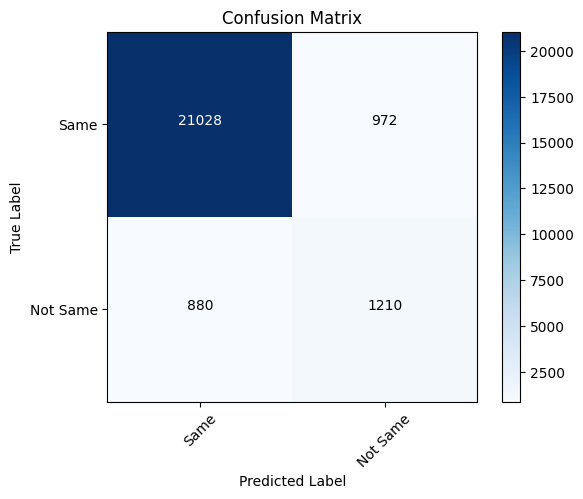

----------Predicting-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.97      0.97      0.97     22000
        Same       0.65      0.66      0.66      2090

    accuracy                           0.94     24090
   macro avg       0.81      0.81      0.81     24090
weighted avg       0.94      0.94      0.94     24090



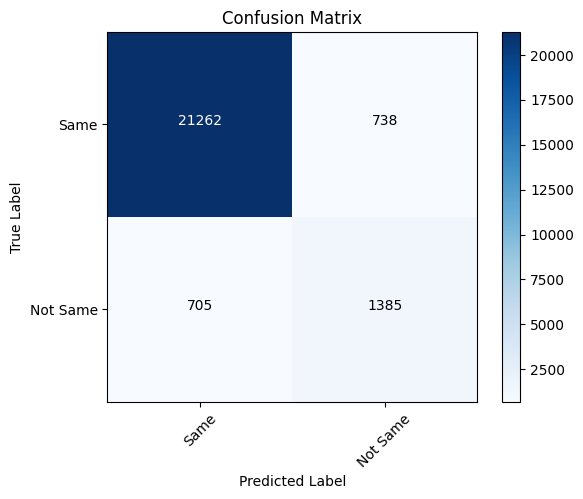

----------Predicting-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.96      0.96      0.96     22000
        Same       0.62      0.62      0.62      2090

    accuracy                           0.93     24090
   macro avg       0.79      0.79      0.79     24090
weighted avg       0.93      0.93      0.93     24090



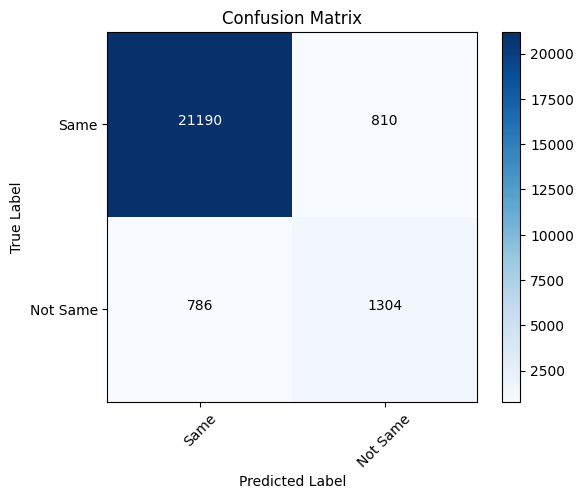

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,399,82,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,399,1278,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,399,1193,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,399,447,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,399,966,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,390,723,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,390,98,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,663,723,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,663,98,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, lsvc_generation, vectorizer_generation)
print_metric_task1(df_aa_paper, label2id, rf_generation, vectorizer_generation)
print_metric_task1(df_aa_paper, label2id, xgb_generation, vectorizer_generation)

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.70      0.75      0.73      1200
        Same       0.39      0.33      0.36       570

    accuracy                           0.62      1770
   macro avg       0.55      0.54      0.54      1770
weighted avg       0.60      0.62      0.61      1770



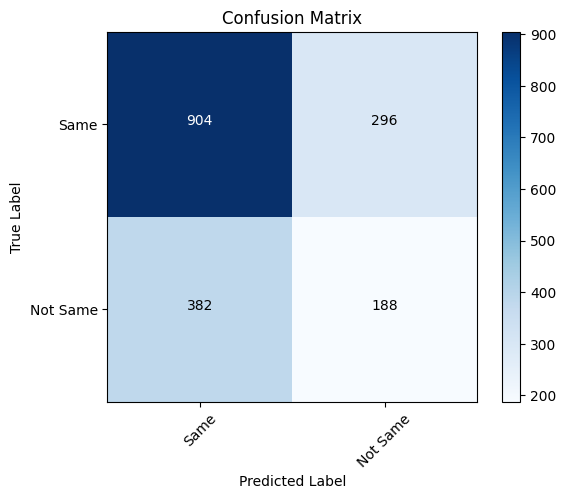

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.70      0.69      0.69      1200
        Same       0.37      0.38      0.37       570

    accuracy                           0.59      1770
   macro avg       0.53      0.53      0.53      1770
weighted avg       0.59      0.59      0.59      1770



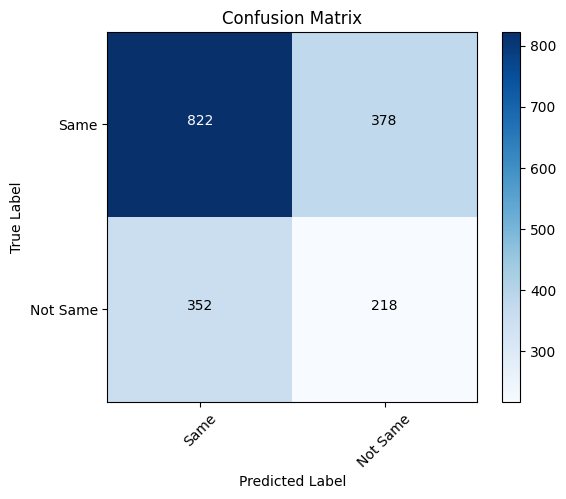

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-6-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.72      0.68      0.70      1200
        Same       0.39      0.44      0.41       570

    accuracy                           0.60      1770
   macro avg       0.55      0.56      0.55      1770
weighted avg       0.61      0.60      0.60      1770



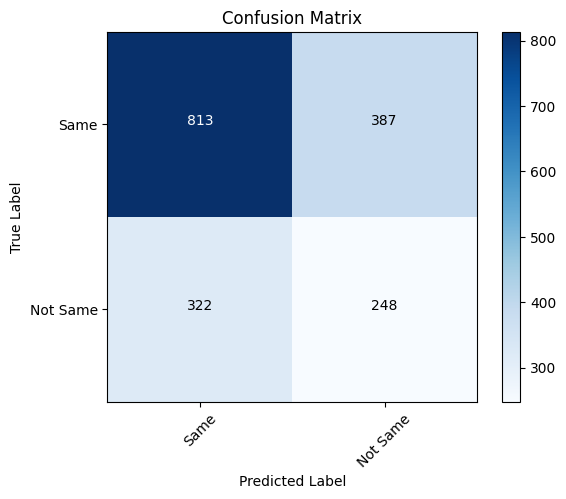

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1061,1689,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
1,1061,1158,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
2,1061,1610,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
3,1061,1303,"(gpt3, gpt3)",Same,"(gpt3, human)",Not Same
4,1061,1472,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
...,...,...,...,...,...,...
1765,2447,1877,"(instructgpt, instructgpt)",Same,"(gpt3, instructgpt)",Not Same
1766,2447,2509,"(instructgpt, instructgpt)",Same,"(gpt3, instructgpt)",Not Same
1767,1830,1877,"(instructgpt, instructgpt)",Same,"(gpt3, instructgpt)",Not Same
1768,1830,2509,"(instructgpt, instructgpt)",Same,"(gpt3, instructgpt)",Not Same


In [ ]:
print_metric_task1(df_reddit, label2id, lsvc_generation, vectorizer_generation, source="reddit")
print_metric_task1(df_reddit, label2id, rf_generation, vectorizer_generation, source="reddit")
print_metric_task1(df_reddit, label2id, xgb_generation, vectorizer_generation, source="reddit")

In [ ]:
test_features_pos = get_features_test(df_aa_paper, vectorizer=vectorizer_pos)

In [ ]:
test_features_pos.shape

(1279, 1648)

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.97      0.97      0.97     22000
        Same       0.71      0.73      0.72      2090

    accuracy                           0.95     24090
   macro avg       0.84      0.85      0.85     24090
weighted avg       0.95      0.95      0.95     24090



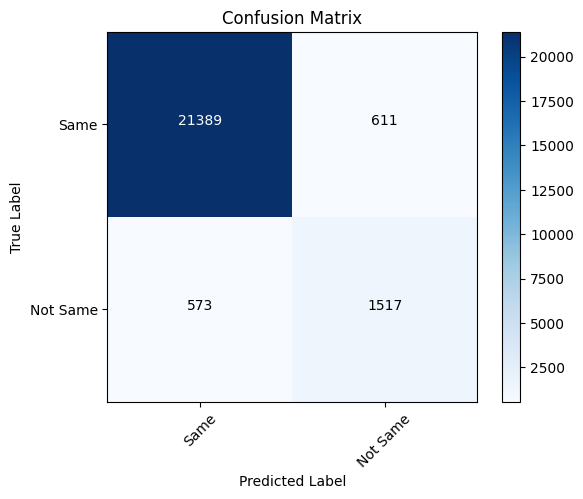

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.98      0.98      0.98     22000
        Same       0.80      0.80      0.80      2090

    accuracy                           0.97     24090
   macro avg       0.89      0.89      0.89     24090
weighted avg       0.97      0.97      0.97     24090



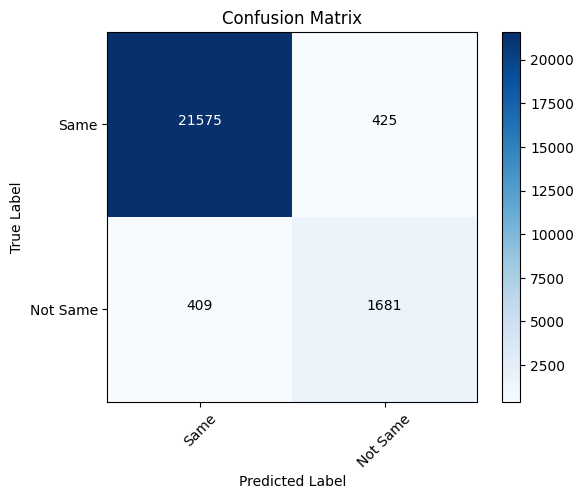

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.99      0.98      0.99     22000
        Same       0.84      0.85      0.84      2090

    accuracy                           0.97     24090
   macro avg       0.91      0.92      0.91     24090
weighted avg       0.97      0.97      0.97     24090



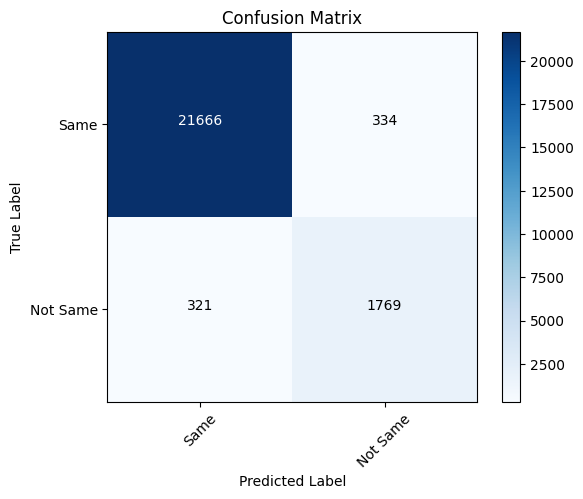

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1245,1038,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,1245,966,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,1245,821,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,1245,133,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,1245,472,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,933,605,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,933,554,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,940,605,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,940,554,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, lsvc_pos, vectorizer_pos)
print_metric_task1(df_aa_paper, label2id, rf_pos, vectorizer_pos)
print_metric_task1(df_aa_paper, label2id, xgb_pos, vectorizer_pos)

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.73      0.71      0.72      1200
        Same       0.42      0.44      0.43       570

    accuracy                           0.62      1770
   macro avg       0.57      0.57      0.57      1770
weighted avg       0.63      0.62      0.62      1770



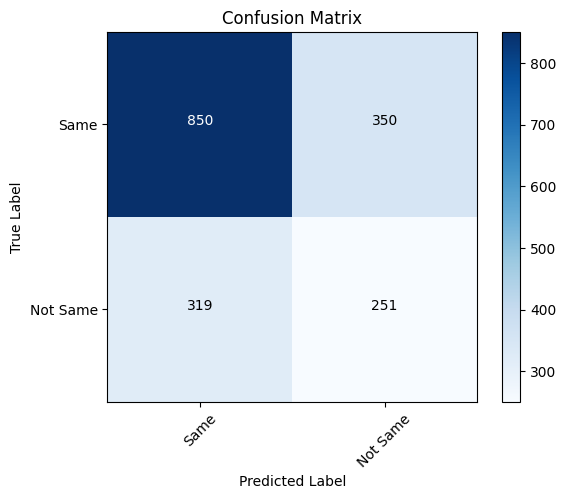

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.72      0.60      0.66      1200
        Same       0.38      0.51      0.43       570

    accuracy                           0.57      1770
   macro avg       0.55      0.56      0.54      1770
weighted avg       0.61      0.57      0.58      1770



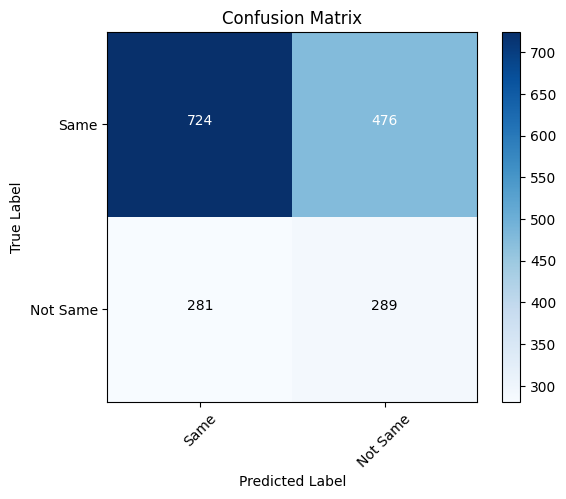

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.69      0.59      0.64      1200
        Same       0.34      0.44      0.38       570

    accuracy                           0.54      1770
   macro avg       0.51      0.51      0.51      1770
weighted avg       0.57      0.54      0.55      1770



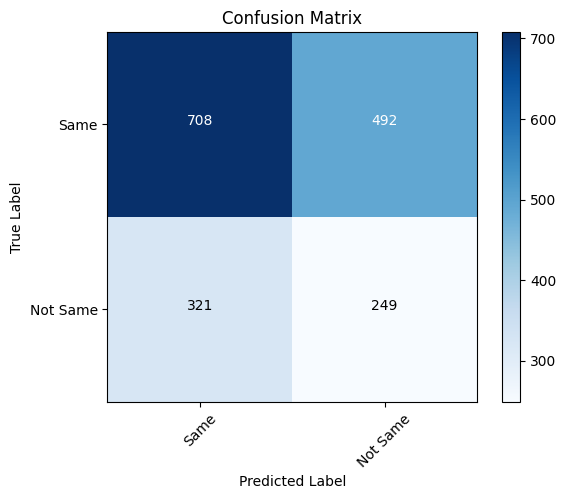

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1018,1092,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
1,1018,1565,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
2,1018,1388,"(gpt3, gpt3)",Same,"(gpt3, instructgpt)",Not Same
3,1018,1685,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
4,1018,1471,"(gpt3, gpt3)",Same,"(gpt3, gpt3)",Same
...,...,...,...,...,...,...
1765,2360,2481,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1766,2360,1886,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1767,2119,2481,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1768,2119,1886,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same


In [ ]:
print_metric_task1(df_reddit, label2id, lsvc_pos, vectorizer_pos, source="reddit")
print_metric_task1(df_reddit, label2id, rf_pos, vectorizer_pos, source="reddit")
print_metric_task1(df_reddit, label2id, xgb_pos, vectorizer_pos, source="reddit")

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.97      0.97      0.97     22000
        Same       0.69      0.72      0.70      2090

    accuracy                           0.95     24090
   macro avg       0.83      0.84      0.84     24090
weighted avg       0.95      0.95      0.95     24090



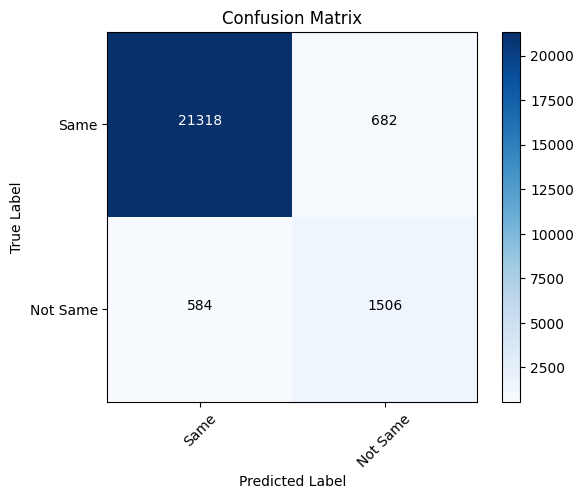

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.98      0.98      0.98     22000
        Same       0.76      0.76      0.76      2090

    accuracy                           0.96     24090
   macro avg       0.87      0.87      0.87     24090
weighted avg       0.96      0.96      0.96     24090



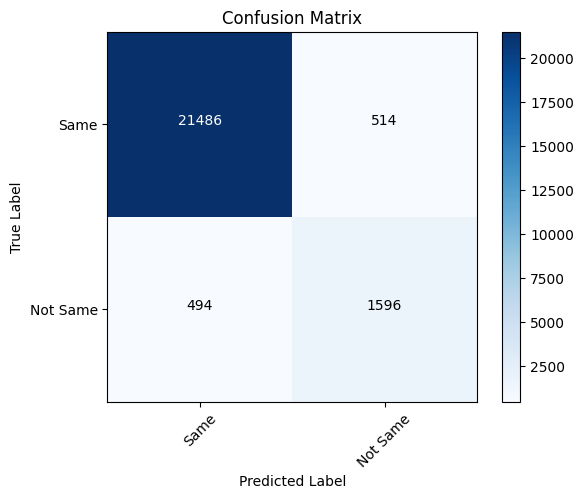

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.99      0.99      0.99     22000
        Same       0.85      0.85      0.85      2090

    accuracy                           0.97     24090
   macro avg       0.92      0.92      0.92     24090
weighted avg       0.97      0.97      0.97     24090



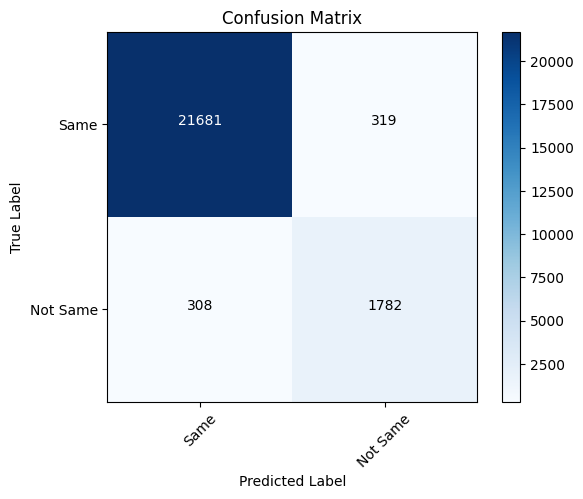

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1038,600,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
1,1038,922,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
2,1038,964,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
3,1038,1161,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
4,1038,1084,"(ctrl, ctrl)",Same,"(ctrl, ctrl)",Same
...,...,...,...,...,...,...
24085,824,1220,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24086,824,1002,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24087,224,1220,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same
24088,224,1002,"(xlnet, xlnet)",Same,"(xlnet, xlnet)",Same


In [ ]:
print_metric_task1(df_aa_paper, label2id, lsvc_pos_dep_liwc, vectorizer_pos_dep_liwc, liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])
print_metric_task1(df_aa_paper, label2id, rf_pos_dep_liwc, vectorizer_pos_dep_liwc, liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])
print_metric_task1(df_aa_paper, label2id, xgb_pos_dep_liwc, vectorizer_pos_dep_liwc, liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.72      0.77      0.74      1200
        Same       0.43      0.36      0.39       570

    accuracy                           0.64      1770
   macro avg       0.57      0.57      0.57      1770
weighted avg       0.62      0.64      0.63      1770



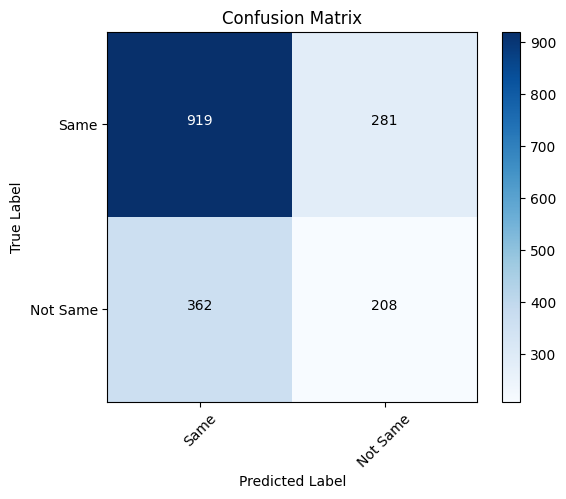

----------Predicting-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


----------Manipulating Data-----------
              precision    recall  f1-score   support

    Not Same       0.76      0.72      0.74      1200
        Same       0.47      0.53      0.50       570

    accuracy                           0.66      1770
   macro avg       0.62      0.62      0.62      1770
weighted avg       0.67      0.66      0.66      1770



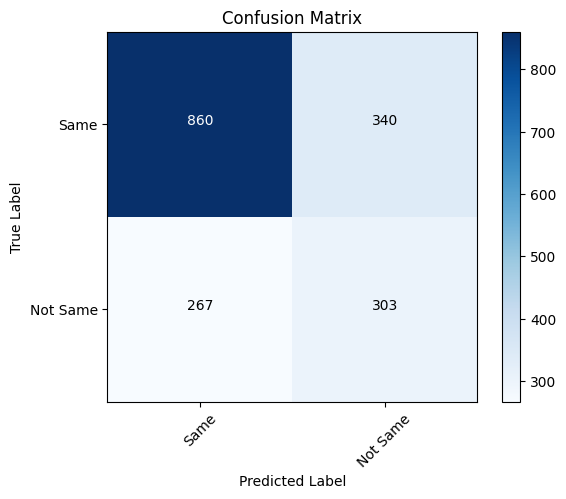

----------Predicting-----------
----------Manipulating Data-----------


<ipython-input-17-a0ddd8ade241>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["pred"] = preds


              precision    recall  f1-score   support

    Not Same       0.72      0.65      0.68      1200
        Same       0.39      0.48      0.43       570

    accuracy                           0.59      1770
   macro avg       0.56      0.56      0.56      1770
weighted avg       0.62      0.59      0.60      1770



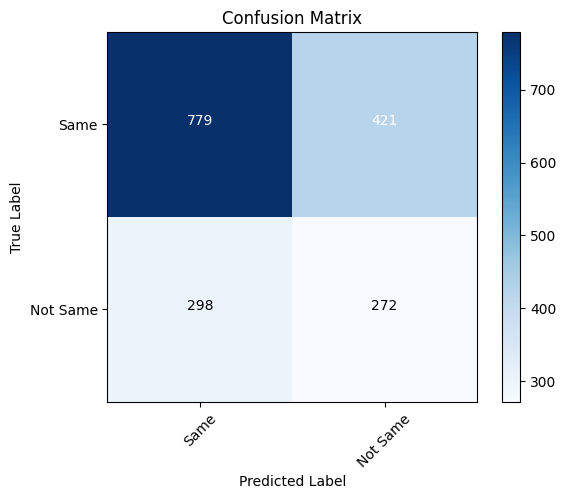

,first_idx,second_idx,true_labels,ground_truth,pred_labels,pred
0,1446,1128,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
1,1446,1233,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
2,1446,1714,"(gpt3, gpt3)",Same,"(instructgpt, instructgpt)",Same
3,1446,1471,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
4,1446,1106,"(gpt3, gpt3)",Same,"(instructgpt, gpt3)",Not Same
...,...,...,...,...,...,...
1765,1962,2347,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1766,1962,2584,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same
1767,2003,2347,"(instructgpt, instructgpt)",Same,"(instructgpt, gpt3)",Not Same
1768,2003,2584,"(instructgpt, instructgpt)",Same,"(instructgpt, instructgpt)",Same


In [ ]:
print_metric_task1(df_reddit, label2id, lsvc_pos_dep_liwc, vectorizer_pos_dep_liwc, source="reddit", liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])
print_metric_task1(df_reddit, label2id, rf_pos_dep_liwc, vectorizer_pos_dep_liwc, source="reddit", liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])
print_metric_task1(df_reddit, label2id, xgb_pos_dep_liwc, vectorizer_pos_dep_liwc, source="reddit", liwc_features=["semantic_coherence", "Analytic", "WPS", "article", "Period"])